In [1]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
# sys.path.append("/private/home/alexandrerame/domainbedv2/")

# sys.path.append("/private/home/alexandrerame/slurmconfig/notebook/data")

# sys.path.append("/home/rame/domainbedv2/")

sys.path.append("/Users/alexandrerame/code_repository/dataplace/data/logs_experiments_notebook/")
sys.path.append("/Users/alexandrerame/code_repository/codedev/domainbedv2")
from domainbed.codeplot import plot

# sys.path.append("/data/rame/logs_experiments_notebook/")

In [2]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times Roman'

SIZE = "large"


class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable
    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    """

    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True):
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360. / len(variables))
        axes = [
            fig.add_axes([0.1, 0.1, 0.9, 0.9], polar=True, label="axes{}".format(i))
            for i in range(len(variables) + 1)
        ]

        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)

        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i == 0 or i == 1) else i - 1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, endpoint=True)
            gridlabel = ["{}".format(round(x, 3)) for x in grid]
            gridlabel[0] = ""  # remove values from the center
            lines, labels = ax.set_rgrids(grid, labels=gridlabel, angle=angles[j])

            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=True)

            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)

        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0

        # Draw (inner) circles and lines
        self.ax.yaxis.grid()
        self.ax.xaxis.grid()

        # Draw outer circle
        self.ax.spines['polar'].set_visible(True)

        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)

        # Create the outer labels for each variable
        # print(angles)
        self.angles_fixed = [angles[0], angles[1]]
        self.angles_fixed.extend(angles[2:])
        if len(self.angles_fixed) == 5:
            self.angles_fixed = [0.0, 72.0-15, 144.0, 216.0, 288.0+15]
        elif len(self.angles_fixed) == 4:
            self.angles_fixed = [0.0, 94.0, 180.0, 267.0]
        #     self.angles_fixed.extend([90, 180, 270])
        #     variables = [v for v in variables] + [r"$R_1$", r"$R_2$", r"$R_3$"]
        print(self.angles_fixed)
        l, text = self.ax.set_thetagrids(self.angles_fixed, labels=variables, color="black")

        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, 1, break_long_words=False)) for l in labels]
        self.ax.set_xticklabels(labels, size=SIZE)

        for t, a in zip(self.ax.get_xticklabels(), angles):
            if a == 0:
                t.set_ha('center')
            elif a > 0 and a < 180:
                t.set_ha('left')
            elif a == 180:
                t.set_ha('center')
            else:
                t.set_ha('right')

        self.ax.tick_params(axis='both', pad=2)

    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d - y1) / (y2 - y1) * (x2 - x1) + x1)
        return sdata

    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter + 1

    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)

    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        self.ax1.legend(*args, **kwargs)

    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title, pad=pad, **kwargs)


In [3]:
from matplotlib import rc
plt.style.use('default')

rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

In [4]:
from captioning import fts_spidercider as fts_spider

In [5]:
dict_clean_labels = {
    "ROUGE_L": r"$ROUGE$",
    "Bleu_1": r"$BLEU1$",
    "Bleu_4": r"$BLEU4$",
    "METEOR": r"$METEOR$",
    "CIDEr": r"$CIDEr$"
}

dict_colormaps = plot.create_colormaps()
cmap_redpurpleblue = plot.matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps)
    ]
)

In [6]:
import math

labels = [
    "Bleu_1",
    "Bleu_4",
    "ROUGE_L",
    "METEOR",
    "CIDEr",
]

def get_minmax(list_ls):
    dict_key_to_minmax = {label: [math.inf, -math.inf] for label in labels}
    for line in list_ls:
        for key in dict_key_to_minmax:
            dict_key_to_minmax[key][0] = min(dict_key_to_minmax[key][0], line[key])
            dict_key_to_minmax[key][1] = max(dict_key_to_minmax[key][1], line[key])
    # for key in dict_key_to_minmax.keys():
    #     dict_key_to_minmax[key].append(dict_key_to_minmax[key][1] - dict_key_to_minmax[key][0])
    return dict_key_to_minmax

dict_key_to_minmax = get_minmax(fts_spider.l.values())

In [7]:
keys = [
    "cidere2e", "bleu1", "bleu4", "rouge", "meteor", "multi", "bleu_rouge_meteor_bleu4_cidere2e"
]
markers = ['o', '^', 'v', '>', '<', '*', 's', 'p', 'h', 'H']
line_labels = [
    # r"RL: $CIDEr$ (init)",
    "Pre-trained init",
    r"RL: $BLEU1$",
    r"RL: $BLEU4$",
    r"RL: $ROUGE$",
    r"RL: $METEOR$",
    r"MORL: $\sum_{i=1}^{N=5} R_i/5$",
    r"RS: $\sum_{i=1}^{N=5} \theta_i/5$"
]

_colormaps = ["Purples", "Blues", "Dark_Blues", "Reds", "Oranges",]
colors = [plot.get_color_from_cmap(cmap, dict_colormaps) for cmap in _colormaps
         ] + ["gold", plot.get_color_from_cmap("Greens", dict_colormaps)]


In [8]:
data = [[fts_spider.l[key][label] for label in labels] for key in keys]


In [9]:
dict_index_to_minmax = {i: dict_key_to_minmax[labels[i]] for i in range(len(labels))}
list_minmax = [dict_key_to_minmax[labels[i]] for i in range(len(labels))]

[0.0, 57.0, 144.0, 216.0, 303.0]


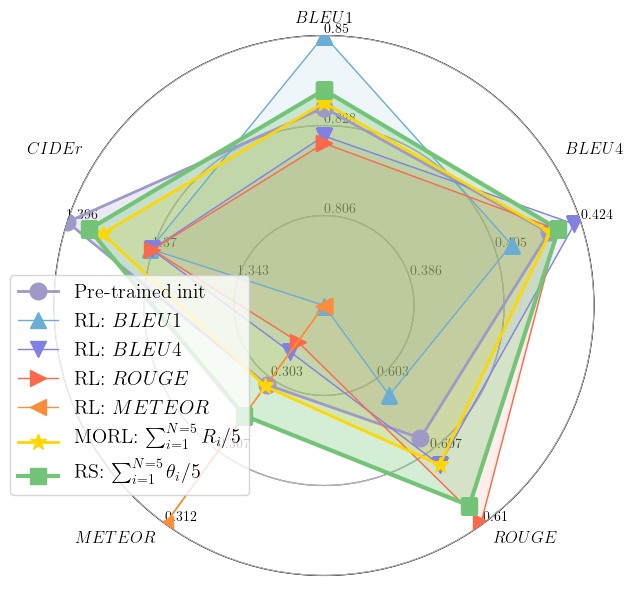

In [10]:
import pandas as pd

ranges = list_minmax

clean_labels = []
result = pd.DataFrame.from_records(
    data, columns=[dict_clean_labels.get(label, label) for label in labels]
)

variables = result.columns

fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges, show_scales=True, n_ring_levels=4)

for g in result.index:
    is_main = (g == (len(keys) - 1))
    is_second = (g == (len(keys) - 2)) or (g == 0)
    radar.plot(
        result.loc[g].values,
        label=line_labels[g],
        color=colors[g],
        marker=markers[g],
        markersize=12,
        linewidth=3 if is_main else (2 if is_second else 1)
    )
    radar.fill(result.loc[g].values, alpha=0.3 if is_main else (0.2 if is_second else 0.1), color=colors[g])

# radar.set_title("Radar chart solution with different scalexs")
radar.use_legend(loc='lower left', bbox_to_anchor=(-0.1, 0.13), fontsize="x-large")
plt.show()

# plot.save_fig(fig=fig1, name="captioning/spider_captioning.pdf", do_save=True)


In [ ]:
radar.angles_fixed

In [ ]:
fig = spider.create_spider_chart(
    data=data,
    labels=labels,
    line_labels=line_labels,
    colors=colors,
    markers=markers,
    # title="Spider map",
    title=None,
    dict_clean_labels=dict_clean_labels,
    dict_key_to_minmax=dict_key_to_minmax,
    num_ticks=5,
    legend_loc=(1.05, 1.0))